# Flexible learning rate schedule design via callbacks
## In this notebook, we explore learning rate schedules, and we use callbacks to develop a method to combine a list of schedules into a single piecewise schedule.

## 1. Prepare to implement a learning rate schedule

### Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

### Import all code from previous notebooks

In [2]:
#export
from exp.nb_04 import *

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7013)

### Get the MNIST training and validation data sets

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
n_hidden,batch_size = 50,512
n_out = y_train.max().item()+1
loss_func = F.cross_entropy

### Package the training and validation datasets into a DataBunch object

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, batch_size), n_out=n_out)

### Export a function that returns a Learner object as a container for model, optimizer, loss_func, and data 

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

### Instantiate Learner and Runner objects, and run the training loop

In [6]:
# instantiate a learner object
#     recall that get_model builds a model, and returns the model, the optimizer, and the learning rate
learn = create_learner(get_model, loss_func, data)
# instantiate a runner object
run = Runner([AvgStatsCallback([accuracy])])
# run the training loop
run.fit(learn, n_epochs=3)

train: [0.671173125, tensor(0.8064)]
valid: [0.2988545166015625, tensor(0.9112)]
train: [0.29452666015625, tensor(0.9140)]
valid: [0.24231240234375, tensor(0.9296)]
train: [0.23670595703125, tensor(0.9317)]
valid: [0.2087354736328125, tensor(0.9424)]


### Instantiate Learner and Runner objects, and run the training loop again, this time changing the learning_rate

In [7]:
# instantiate a learner object
learn = create_learner(partial(get_model, learning_rate=0.3), loss_func, data)
# instantiate a runner object
run = Runner([AvgStatsCallback([accuracy])])
# run the training loop for 3 epochs
run.fit(learn, n_epochs=3)

train: [0.77214640625, tensor(0.7895)]
valid: [0.36876806640625, tensor(0.8990)]
train: [0.3571534375, tensor(0.8973)]
valid: [0.30528232421875, tensor(0.9121)]
train: [0.3065955859375, tensor(0.9118)]
valid: [0.2714761962890625, tensor(0.9218)]


### Export a partial get_model function that takes only a learning rate as input 

In [8]:
#export
def get_model_func(learning_rate=0.5): 
    return partial(get_model, learning_rate=learning_rate)

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7202)

## 2. Learning rate schedules

### Linear learning rate schedule
Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7431)

In [9]:
# linear schedule
def sched_lin(start, end):
    def _inner(start, end, pos): 
        return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7526)

In [10]:
#export
def annealer(f):
    def _inner(start, end): 
        return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): 
    return start + pos*(end-start)

In [11]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [12]:
f = sched_lin(1,2)
f(0.3)

1.3

### Other learning rate schedules: cosine, constant, exponential, beta
And here are other scheduler functions:

In [13]:
#export

# note that it's 'cheating' to import the beta function and numpy
from scipy.stats import beta
import numpy as np

@annealer
# cosine schedule
def sched_cos(start, end, pos): 
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
# constant schedule
@annealer
def sched_no(start, end, pos):  
    return start
# exponential schedule
@annealer
def sched_exp(start, end, pos): 
    return start * (end/start) ** pos
# betafunction schedule
@annealer
def sched_beta(start, end, pos):
    a, b = 2.5, 5.
    x = np.linspace(0.,1.0,100)
    beta_func = beta.pdf(x, a, b)
    scaled_pos = pos/(end-start)
    scale = 0.8
    return scale*np.interp(pos, x, beta_func)

#Add an ndim property to the Tensor class so that tensors can be plotted
torch.Tensor.ndim = property(lambda x: len(x.shape))

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7730)

### Let's visualize these learning rate schedules

Text(0, 0.5, 'learning rate')

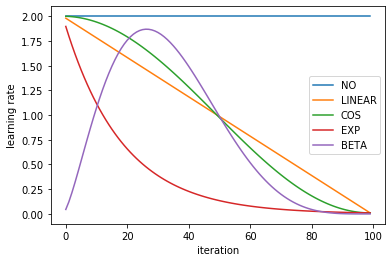

In [14]:
# setup range of iteration indices
n_points = 100
start_point = 0
indices = torch.arange(0, n_points)

# uniformly sample 100 points on the interval [0,1] at step size of  of x_step
x_start = 0.01
x_end = 1
x_step = 0.01
points = torch.linspace(x_start,x_end,n_points)

# plot the annealing schedules
begin_learning_rate = 2.
end_learning_rate = 0.01
annealing_labels = "NO LINEAR COS EXP BETA".split()
annealing_funcs = [sched_no, sched_lin, sched_cos, sched_exp, sched_beta]
for func, label in zip(annealing_funcs, annealing_labels):
    annealing_schedule = func(begin_learning_rate, end_learning_rate)
    plt.plot(indices, [annealing_schedule(pos) for pos in points], label=label)
plt.legend()
plt.xlabel('iteration')
plt.ylabel('learning rate')

### Constructing Piecewise Schedules by Combining Schedulers 
In practice, we'll often want to combine different schedulers, the following function creates a piecewise schedule that uses `scheds[i]` for `fracs[i]` of the training.

In [15]:
#export
def combine_scheds(fracs, scheds):
    
    # check that all fracs are positive and that they sum to 1
    assert sum(fracs) == 1.
    fracs = tensor([0] + listify(fracs))
    assert torch.all(fracs >= 0)
    
    # relative position (between 0 and 1) at the boundary of each piecewise section of the schedule
    cum_fracs = torch.cumsum(fracs, 0)
    
    def _inner(pos):
        # given a relative position pos (between 0 and 1) along the schedule interval
        #    if pos doesn't correspond to a section boundary point,
        #        compute the index of the nearest section boundary point to its left in cum_fracs;
        #    otherwise return the index corresponding to pos in cum_fracs
        idx = (pos >= cum_fracs).nonzero().max()
        # print('index = ',idx)
        # compute the relative position of pos within its piecewise section interval; ranges from 0 to 1
        actual_pos = (pos-cum_fracs[idx]) / (cum_fracs[idx+1]-cum_fracs[idx])
        return scheds[idx](actual_pos)
    # return the scheduler function
    return _inner

Example 1: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [16]:
# specify and create a piecewise schedule
sched = combine_scheds([0.3,0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

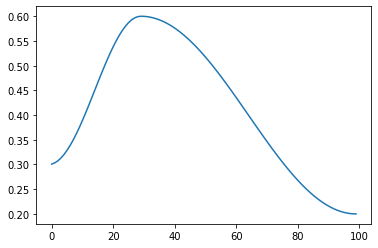

In [17]:
# plot the piecewise schedule
plt.plot(indices, [sched(pos) for pos in points])

Example 2: use 60% of the budget to go from 0.2 to 0.9 following an exp, the 20% of the budget with a constant, then the last 20% of the budget to go from 0.9 to 0.05, still following an exp.

In [18]:
# specify and create a piecewise schedule
sched = combine_scheds([0.6,0.2,.2], [sched_exp(0.2, 0.9),sched_no(0.9, 0.9), sched_exp(0.9, 0.05)]) 

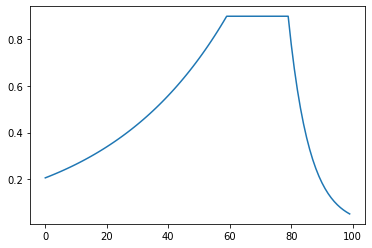

In [19]:
# plot the piecewise schedule
plt.plot(indices, [sched(pos) for pos in points])

### The beta function schedule
The **beta function** is defined on the interval [0,1]. It has a varying shape that is controlled by its two input parameters $a$ and $b$. When $a\gt 1$ and $b\gt 1$, the **beta function** is convex and vanishes at the boundaries of [0,1], allowing the construction of smooth learning rate schedules that start and end with a learning rate near zero.

The **beta function** is defined on the interval [0,1], and has a varying shape that is controlled by its two input parameters a and b. When $a$ and $b$ are both greater than 1, the beta function is convex and vanishes at 0 and 1, allowing the construction of smooth learning rate schedules that start and end with a learning rate near zero. See the purple curve in the first figure above. You can play with the beta function schedule by varying the values of $a$ and $b$.

In [20]:
sched = sched_beta(0.1,0.9)

## 3. Flexible learning rate schedule design via callbacks

### Recorder and ParamScheduler callbacks
We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

In [21]:
#export
class Recorder(Callback):
    def begin_fit(self): 
        self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['learning_rate'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): 
        plt.plot(self.lrs)
    def plot_loss(self): 
        plt.plot(self.losses)

class ParamScheduler(Callback):
    # order parameter
    _order=1
    def __init__(self, pname, sched_func): 
        self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for param_group in self.opt.param_groups:
            # print(self.epoch, self.n_epochs_float)
            # param_group[self.pname] = self.sched_func((self.epoch+self.n_epochs_float)/(self.epoch+1))
            param_group[self.pname] = self.sched_func((self.n_epochs_float+self.epoch)/self.n_epochs)
            
    def begin_batch(self): 
        if self.in_train: 
            self.set_param()

We can use it for training quite easily...

In [22]:
# create the list of callbacks we want to use
callback_funcs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'learning_rate', sched)]

In [23]:
# instantiate Learner and Runner objects
learn = create_learner(get_model_func(learning_rate = 0.3), loss_func, data)
run = Runner(callback_funcs=callback_funcs)

In [24]:
# run the schedule
run.fit(learn, n_epochs = 3)

train: [0.75736609375, tensor(0.8017)]
valid: [0.3507255126953125, tensor(0.9033)]
train: [0.341644375, tensor(0.9032)]
valid: [0.2810364990234375, tensor(0.9194)]
train: [0.2912229296875, tensor(0.9167)]
valid: [0.253419287109375, tensor(0.9285)]


... then check with our recorder if the learning rate followed the right schedule.

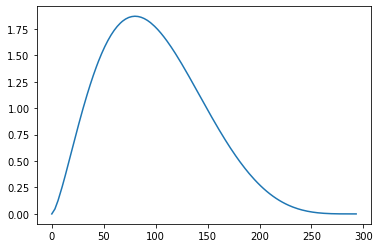

In [25]:
# plot the learning rate schedule
run.recorder.plot_lr()

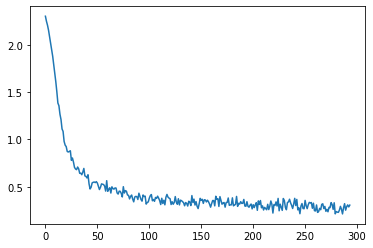

In [26]:
# plot the loss
run.recorder.plot_loss()

## Export

In [27]:
!python notebook2script.py 05_anneal_jcat.ipynb

Converted 05_anneal_jcat.ipynb to exp\nb_05.py
